In [296]:
import pandas as pd
import numpy as np
import math
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

pd.set_option('display.max_columns', None)

In [297]:
train = pd.read_csv("train.csv", decimal=',')
test = pd.read_csv("test.csv", decimal=',')
n = (train.state.unique()[0])

In [298]:
train['size'] = train['size'].str.replace('full-size', 'fullsize').replace('fullーsize', 'fullsize').replace('full−size', 'fullsize').replace('mid-size', 'midsize').replace('midーsize', 'midsize').replace('mid−size', 'midsize').replace('sub-compact','subcompact').replace('subーcompact', 'subcompact')
test['size'] = test['size'].str.replace('full-size', 'fullsize').replace('fullーsize', 'fullsize').replace('full−size', 'fullsize').replace('mid-size', 'midsize').replace('midーsize', 'midsize').replace('mid−size', 'midsize').replace('sub-compact','subcompact').replace('subーcompact', 'subcompact')

In [299]:
train["region"] = train["region"].apply(lambda x: x.replace("/", "nn").replace(",", " "))
test["region"] = test["region"].apply(lambda x: x.replace("/", "nn").replace(",", " "))

In [300]:
def to_half_width(text):
    return ''.join([unicodedata.normalize('NFKC', char).lower().replace("а", "a").replace("ѕ", "s").replace("о", "o").replace("α", "a") for char in text])

train["manufacturer"] = train["manufacturer"].apply(to_half_width)
test["manufacturer"] = test["manufacturer"].apply(to_half_width)

In [301]:
train.odometer[train.odometer < 0] = 0
test.odometer[test.odometer < 0] = 0
train.year[train.year > 2023] -= 1000
test.year[test.year > 2023] -= 1000
train.odometer[train.odometer >= 1000000] /= 10
test.odometer[test.odometer >= 1000000] /= 10

C:\Users\81703\AppData\Local\Temp\ipykernel_10796\982428449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.odometer[train.odometer < 0] = 0
C:\Users\81703\AppData\Local\Temp\ipykernel_10796\982428449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.odometer[test.odometer < 0] = 0
C:\Users\81703\AppData\Local\Temp\ipykernel_10796\982428449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.year[train.year > 202

In [305]:
train.columns[train.dtypes == "object"]

Index(['region', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
       'state'],
      dtype='object')

In [280]:
# l = {"dc": [9856, 68], "nj": [1195, 8722], "ri": [1018, 1544], "ma": [839, 10554], "ct": [738, 5543],
#      "md": [594, 12405], "de": [460, 2488], "ny": [4141, 54554], "fl": [350, 65757], "pa": [282, 46054],
#      "oh": [282, 44825], "ca": [239, 163694], "il": [231, 57913], "hi": [211, 10931], "va": [202, 42774],
#      "nc": [196, 53819], "in": [180, 36419], "mi": [174, 96713], "ga": [168, 59425], "tn": [153, 42144],
#      "sc": [153, 32020], "nh": [147, 9346], "ky": [109, 40407], "wi": [105, 65496], "la": [104, 52378],
#      "wa": [101, 71297], "tx": [96, 268596], "al": [94, 52420], "mo": [87, 69706], "wv": [77, 24230],
#      "vt": [67, 9616], "mn": [66, 86935], "ms": [63, 48431], "az": [56, 113990], "ar": [56, 53178],
#      "ok": [54, 69898], "ia": [54, 56272], "co": [48, 104093], "me": [43, 35379], "or": [39, 98378],
#      "ks": [34, 82278], "ut": [33, 84896], "nv": [24, 110571], "ne": [23, 77347], "id": [18, 83568],
#      "nm": [16, 121590], "sd": [10, 77115], "nd": [9, 70698], "mt": [6, 147039], "wy": [5, 97813], "ak": [1, 665384]}

# man = {'bmw': 47200, 'toyota': 26500, 'ford': 24500, 'nissan': 22500, 'volkswagen': 21500, 'lexus': 43500, 'buick': 27500,
#        'subaru': 25500, 'ram': 32500, 'dodge': 28500, 'chevrolet': 25500, 'jeep': 30500, 'honda': 24500, 'hyundai': 23500,
#        'chrysler': 29500, 'gmc': 34500, 'mazda': 26500, 'audi': 45500, 'lincoln': 49500, 'kia': 22500,
#        'mercedes-benz': 58500, 'mitsubishi': 20500, 'saturn': 25500, 'infiniti': 41500, 'mini': 29500,
#        'mercury': 28500, 'cadillac': 52500, 'pontiac': 27500, 'acura': 38500, 'fiat': 21500, 'jaguar': 56500,
#        'volvo': 37500, 'rover': 33500, 'porsche': 72500, 'land rover': 64500, 'aston-martin': 109500,
#        'alfa-romeo': 49500, 'ᴄhrysler': 29500}

In [281]:
# train['state_pd'] = n
# test['state_pd'] = n
# train['state_area'] = n
# test['state_area'] = n
# train['state_pop'] = n
# test['state_pop'] = n
# train['man_ave'] = n
# test['man_ave'] = n
# for i in range(train.id.shape[0]):
#     if type(train["state"][i]) == str:
#         train['state_pd'][i] = l[train.state[i]][0]
#         train['state_area'][i] = l[train.state[i]][1]
#         train['state_pop'][i] = l[train.state[i]][0] * l[train.state[i]][1]
#         train['man_ave'][i] = man[train.manufacturer[i]]

# for i in range(test.id.shape[0]):
#     if type(test.state[i]) == str:
#         test.state_pd[i] = l[test.state[i]][0]
#         test.state_area[i] = l[test.state[i]][1]
#         test.state_pop[i] = l[test.state[i]][0] * l[test.state[i]][1]
#         test.man_ave[i] = man[test.manufacturer[i]]

# train = train.fillna({"state_pd": train.state_pd.mean(), "state_area": train.state_area.mean(), "state_pop": train.state_pop.mean(), "man_ave": train.man_ave.mean(), "condition": train.condition.mean()})
# test = test.fillna({"state_pd": test.state_pd.mean(), "state_area": test.state_area.mean(), "state_pop": test.state_pop.mean(), "man_ave": test.man_ave.mean(), "condition": test.condition.mean()})

In [282]:
#separating categorical and numerical features
categorical_features=[feature for feature in train.columns if train[feature].dtype=='object']
numerical_features=[feature for feature in train.columns if feature not in categorical_features]

<Figure size 1000x1000 with 0 Axes>

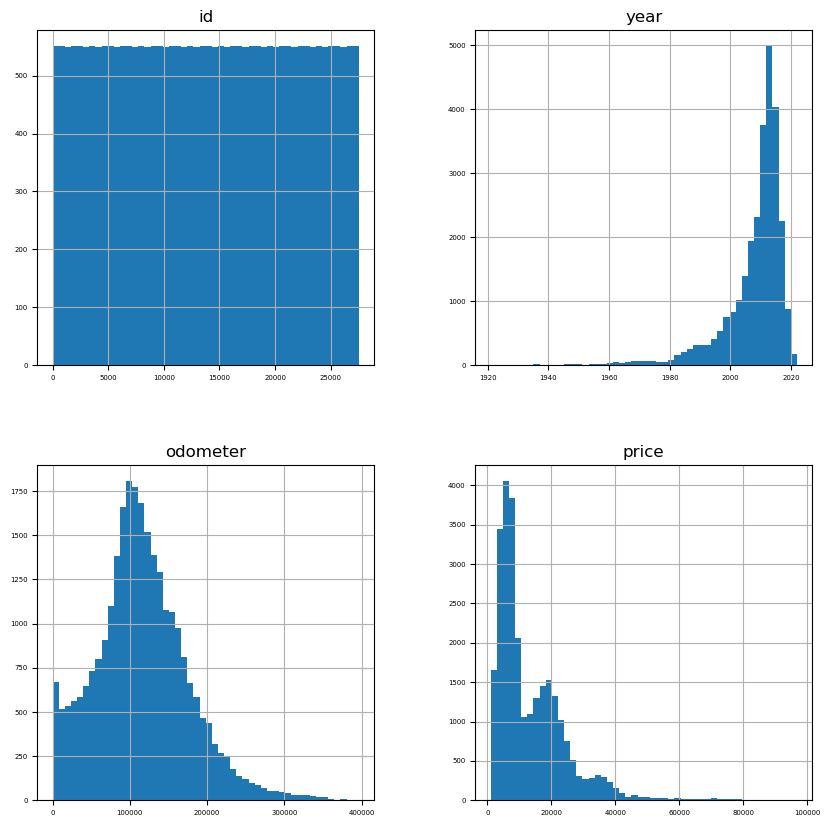

In [283]:
train_num=train[numerical_features]
plt.figure(figsize=(10,10))
train_num.hist(figsize=(10,10),bins=50, xlabelsize=5, ylabelsize=5)
plt.show()

<Axes: >

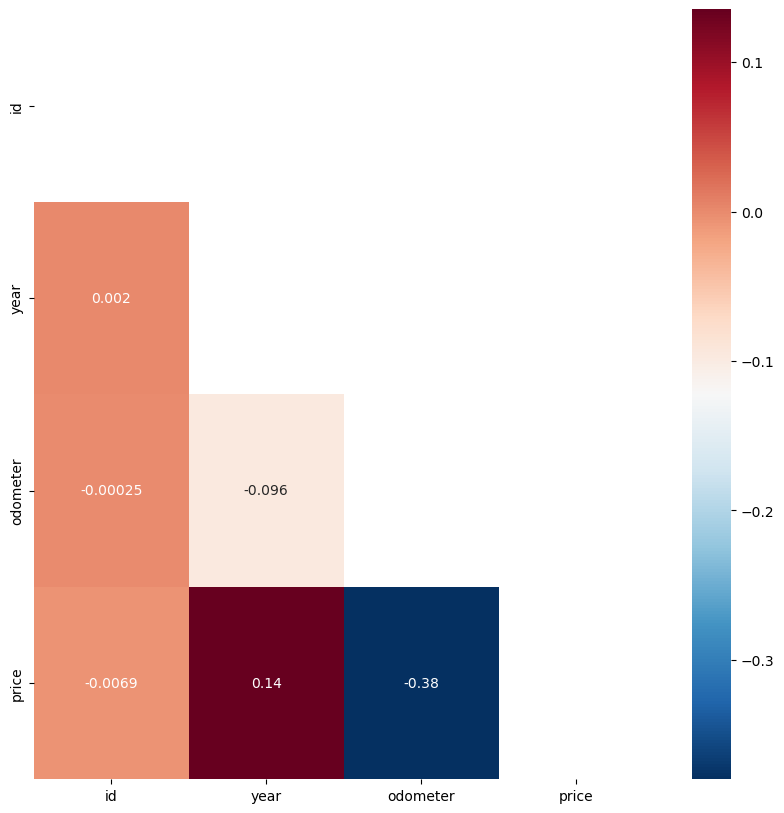

In [284]:
#correlation heatmap
plt.figure(figsize=(10,10))
corr=train_num.corr()
msk = np.triu(np.ones_like(corr))
sns.heatmap(corr,cmap=plt.cm.RdBu_r,annot=True,annot_kws={'size':10},mask=msk)

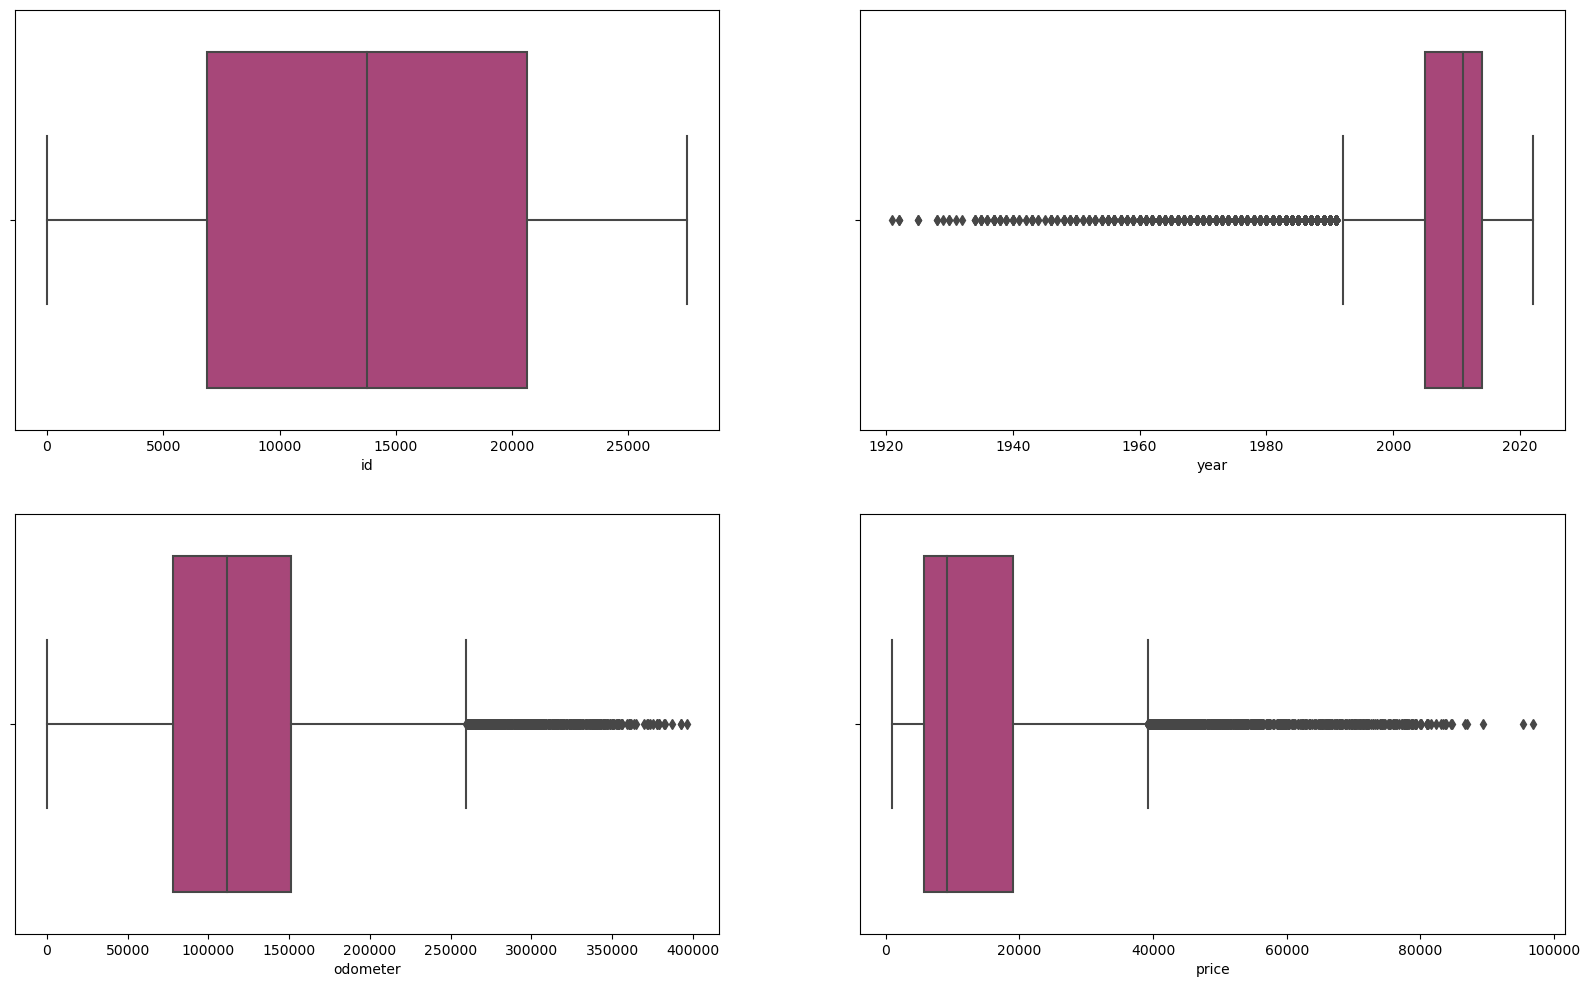

In [285]:
#visualization of numerical features using box plot to determine/remove extreme outliers
n_row=2
n_col=2

fig,ax=plt.subplots(nrows=n_row,ncols=n_col,figsize=(20,6*n_row))
i=0  #for row number
for feature in numerical_features:
    n=i//n_col   #for row no.
    m=i%n_col    #for col no.
    sns.boxplot(x=feature,data=train,palette='magma',ax=ax[n,m])
    i+=1

In [286]:
#for determining no. of unique categories for each feature
dict_={}
for feature in categorical_features:
    dict_[feature]=train[feature].value_counts().shape[0]
pd.DataFrame(dict_,index=['unique_counts']).transpose()

,unique_counts
region,372
manufacturer,38
condition,6
cylinders,8
fuel,5
title_status,6
transmission,3
drive,3
size,4
type,13


In [287]:
dict(np.argsort(train.groupby("condition").mean().price))

C:\Users\81703\AppData\Local\Temp\ipykernel_10796\421074024.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dict(np.argsort(train.groupby("condition").mean().price))


{'excellent': 1, 'fair': 5, 'good': 2, 'like new': 0, 'new': 4, 'salvage': 3}

In [288]:
for i in train.describe(include="O").columns:
    ma = dict(np.argsort(train.groupby(i).mean().price))
    train[i] = train[i].map(ma)
    test[i] = test[i].map(ma)
    train = train.fillna({i: train[i].mean()})
    test = test.fillna({i: test[i].mean()})

C:\Users\81703\AppData\Local\Temp\ipykernel_10796\3987123742.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ma = dict(np.argsort(train.groupby(i).mean().price))
C:\Users\81703\AppData\Local\Temp\ipykernel_10796\3987123742.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ma = dict(np.argsort(train.groupby(i).mean().price))
C:\Users\81703\AppData\Local\Temp\ipykernel_10796\3987123742.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be va

In [289]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27532 entries, 0 to 27531
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            27532 non-null  int64  
 1   region        27532 non-null  int64  
 2   year          27532 non-null  int64  
 3   manufacturer  27532 non-null  int64  
 4   condition     27532 non-null  int64  
 5   cylinders     27532 non-null  int64  
 6   fuel          27532 non-null  float64
 7   odometer      27532 non-null  int64  
 8   title_status  27532 non-null  float64
 9   transmission  27532 non-null  int64  
 10  drive         27532 non-null  int64  
 11  size          27532 non-null  int64  
 12  type          27532 non-null  float64
 13  paint_color   27532 non-null  int64  
 14  state         27532 non-null  float64
 15  price         27532 non-null  int64  
dtypes: float64(4), int64(12)
memory usage: 3.4 MB


In [290]:
cols = ["year", "odometer"] #, "state_pd", "state_area", "state_pop", "man_ave"]
nu = 5
for i in np.arange(2, nu):
    for c in cols:
        train[f"{c}{i}"] = train[c] ** i
        test[f"{c}{i}"] = test[c] ** i

In [291]:
train.columns

Index(['id', 'region', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state', 'price', 'year2', 'odometer2', 'year3',
       'odometer3', 'year4', 'odometer4'],
      dtype='object')

In [292]:
# col = ['id', "region", "manufacturer", "title_status", "transmission", "state", "odometer4"]
# train.drop(col, axis=1, inplace=True)
# test.drop(col, axis=1, inplace=True)

In [293]:
train.corr().price

id             -0.006868
region         -0.029890
year            0.135296
manufacturer   -0.055378
condition      -0.227237
cylinders      -0.207885
fuel           -0.276608
odometer       -0.379853
title_status    0.046430
transmission   -0.053892
drive          -0.282415
size            0.202872
type           -0.220914
paint_color    -0.167797
state          -0.032063
price           1.000000
year2           0.136706
odometer2      -0.307163
year3           0.138107
odometer3      -0.239124
year4           0.139498
odometer4       0.027837
Name: price, dtype: float64

In [294]:
train.to_csv("train3.csv", index=False)
test.to_csv("test3.csv", index=False)

In [295]:
train.describe()

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price,year2,odometer2,year3,odometer3,year4,odometer4
count,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,27532.000000,2.753200e+04,2.753200e+04,2.753200e+04,2.753200e+04,2.753200e+04,2.753200e+04
mean,13765.500000,182.823115,2007.687673,20.365393,1.437673,3.629631,3.887042,115710.269069,2.206604,1.191668,1.354787,2.283270,8.545982,4.903131,26.725070,13468.724829,4.030912e+06,1.698322e+10,8.093222e+09,2.916812e+15,1.624988e+13,1.914487e+17
std,7947.948142,110.028668,10.123062,9.781731,1.259075,2.598063,0.348647,59954.051292,0.712040,0.467752,0.761636,0.971195,3.993983,3.545194,12.269665,10962.149840,4.038429e+04,1.686659e+10,1.208421e+08,4.730621e+15,3.214510e+11,5.094924e+18
min,0.000000,0.000000,1921.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1004.000000,3.690241e+06,0.000000e+00,7.088953e+09,0.000000e+00,1.361788e+13,-9.221863e+18
25%,6882.750000,82.000000,2005.000000,13.000000,1.000000,2.000000,4.000000,78367.750000,2.000000,1.000000,1.000000,2.000000,5.000000,2.000000,18.000000,5759.000000,4.020025e+06,6.141504e+09,8.060150e+09,4.812959e+14,1.616060e+13,-4.030861e+18
50%,13765.500000,193.000000,2011.000000,17.000000,1.000000,2.000000,4.000000,111444.500000,2.000000,1.000000,2.000000,3.000000,11.000000,4.000000,26.725070,9206.000000,4.044121e+06,1.241988e+10,8.132727e+09,1.384127e+15,1.635491e+13,2.146492e+17
75%,20648.250000,278.000000,2014.000000,28.000000,2.000000,7.000000,4.000000,150837.000000,2.000000,1.000000,2.000000,3.000000,12.000000,8.000000,36.000000,19128.000000,4.056196e+06,2.275180e+10,8.169179e+09,3.431813e+15,1.645273e+13,4.332658e+18
max,27531.000000,371.000000,2022.000000,37.000000,5.000000,7.000000,4.000000,396512.000000,5.000000,2.000000,2.000000,3.000000,12.000000,11.000000,50.000000,96818.000000,4.088484e+06,1.572218e+11,8.266915e+09,6.234032e+16,1.671570e+13,9.223236e+18
